<a href="https://colab.research.google.com/github/juanxo90/Data-science-OPI/blob/main/OPI_ciencia_de_datos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análisis de datos abiertos de la CDMX.

A partir de los datos publicados por la agencia Digital de Inovación Pública (datos asociados a las carpetas de investigación de la PGJ). se realizará la exploración, análisis e interpretación de la tabla, de acuerdo a las diferentes preguntas planteadas a continuación.



## Identifica los delitos que van a la alza y a la baja en la CDMX (ten cuidado con los delitos con pocas ocurrencias).

Vamos a analizar la base de datos a partir y calcular la alza y baja en delitos.

In [ ]:
# importamos la librerias 
import numpy as np
import pandas as pd
import datetime as dt

# graficación 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [ ]:
# cargamos la base de datos (SER PACIENTES LA BASE DE DATOS ES UN POCO GRANDE )
url = 'https://archivo.datos.cdmx.gob.mx/fiscalia-general-de-justicia/carpetas-de-investigacion-fgj-de-la-ciudad-de-mexico/carpetas_completa_septiembre_2021.csv'
data = pd.read_csv(url, low_memory=False)

In [ ]:
data.columns

Index(['ao_hechos', 'mes_hechos', 'fecha_hechos', 'ao_inicio', 'mes_inicio',
       'fecha_inicio', 'delito', 'fiscalia', 'agencia', 'unidad_investigacion',
       'categoria_delito', 'calle_hechos', 'calle_hechos2', 'colonia_hechos',
       'alcaldia_hechos', 'competencia', 'longitud', 'latitud', 'tempo'],
      dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1307211 entries, 0 to 1307210
Data columns (total 19 columns):
 #   Column                Non-Null Count    Dtype  
---  ------                --------------    -----  
 0   ao_hechos             1306767 non-null  float64
 1   mes_hechos            1306767 non-null  object 
 2   fecha_hechos          1306767 non-null  object 
 3   ao_inicio             1307211 non-null  int64  
 4   mes_inicio            1307211 non-null  object 
 5   fecha_inicio          1307208 non-null  object 
 6   delito                1307211 non-null  object 
 7   fiscalia              1307209 non-null  object 
 8   agencia               1307211 non-null  object 
 9   unidad_investigacion  1306984 non-null  object 
 10  categoria_delito      1307211 non-null  object 
 11  calle_hechos          1303945 non-null  object 
 12  calle_hechos2         507656 non-null   object 
 13  colonia_hechos        1252553 non-null  object 
 14  alcaldia_hechos       1303432 non-

In [ ]:
# descartamos los datos na en las fechas
data = data.dropna(subset=['ao_hechos','fecha_inicio'])

In [ ]:
# convertimos las fechas
data['fecha_hechos'] = pd.to_datetime(data['fecha_hechos'])
data['fecha_inicio'] = pd.to_datetime(data['fecha_inicio'])

In [ ]:
# Convertimos a series de tiempo por dias
dataTs = data.groupby([pd.Grouper(key='fecha_hechos', freq='D'), 'delito']).size().to_frame().reset_index()
dataTs = dataTs.set_index('fecha_hechos')
dataTs = dataTs.rename(columns={0:'num_del'})
dataTs.head()

,delito,num_del
fecha_hechos,,
1906-06-02,VIOLENCIA FAMILIAR,1
1915-01-10,FRAUDE,1
1915-09-10,ROBO A PASAJERO A BORDO DE METRO SIN VIOLENCIA,1
1930-02-16,ROBO DE OBJETOS,1
1942-10-22,VIOLENCIA FAMILIAR,1


In [ ]:
# filtramos el total de delitos y asi determinar cuales son mejores de analizar aquellos con una incidencia mayor a 500 en toda la serie de tiempo
# el filtrado se hace para evitar analizar los datos que incluso podrían tener pocas incidencias en un periodo amplio
delitos = dataTs.groupby('delito').count().sort_values(by='num_del').reset_index()
delitos = delitos[delitos['num_del'] > 500]
print(delitos)

# filtramos el dataset para obtener los datos delitos
dataTsF = dataTs[dataTs['delito'].isin(delitos['delito'])]

                                                delito  num_del
215  ROBO A PASAJERO / CONDUCTOR DE TAXI CON VIOLENCIA      505
216                             PORTACION ARMA/PROHIB.      506
217                                 COBRANZA ILEGITIMA      508
218  ROBO A TRANSEUNTE A BORDO DE TAXI PÚBLICO Y PR...      508
219              RESPONSABILIDAD PROFESIONAL Y TECNICA      510
..                                                 ...      ...
340                                            DESPOJO     2599
341                                 DENUNCIA DE HECHOS     2671
342                                 VIOLENCIA FAMILIAR     2682
343                                 ABUSO DE CONFIANZA     2720
344                                             FRAUDE     4166

[130 rows x 2 columns]


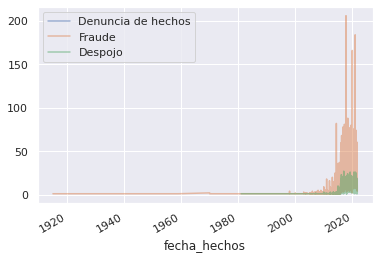

In [ ]:
# analizamos el gráfico de 2 o 3 delitos para ver su comportamiendo inicial
ax = dataTsF[dataTsF['delito'] == 'DENUNCIA DE HECHOS	'].drop(columns=['delito']).plot(alpha=0.5, style='-')
dataTsF[dataTsF['delito'] == 'FRAUDE'].drop(columns=['delito']).plot(alpha=0.5, style='-', ax=ax)
dataTsF[dataTsF['delito'] == 'DESPOJO'].drop(columns=['delito']).plot(alpha=0.5, style='-', ax=ax)
ax.legend(["Denuncia de hechos", "Fraude", "Despojo"]);

In [ ]:
# filtramos el dataset para obtener los datos de los ultimos 6 anos por semana
# pues al parecer la incidencia de los delitos antes del 2015 no es significativa y solo van a la alza
df = data.groupby([pd.Grouper(key='fecha_hechos', freq='D'), 'delito']).size().to_frame().reset_index()
df = df.set_index('fecha_hechos')
df = df.rename(columns={0:'num_del'})
df = df[df['delito'].isin(delitos['delito'])]
df = df[df.index > '2014']

In [ ]:
# Para hacer el forecasting y analizar antes todos los datos analizaremos el delito de fraude por separado
df_frau = df[df['delito'] == 'FRAUDE'].drop(columns=['delito'])

In [ ]:
# graficamos la serie de tiempo en un slider
import plotly.express as px
fig = px.line()
fig.add_scatter(x=df_frau.index, y=df_frau['num_del'], name='Original')
fig.add_scatter(x=df_frau.resample('M').mean().index, y=df_frau.resample('M').mean()['num_del'], name='Re muestreo por mes')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.show()

In [ ]:
# graficamos la serie de tiempo en un slider para violencia familiar
df_vf = df[df['delito'] == 'VIOLENCIA FAMILIAR'].drop(columns=['delito'])
fig = px.line()
fig.add_scatter(x=df_vf.index, y=df_vf['num_del'], name='Original')
fig.add_scatter(x=df_vf.resample('M').mean().index, y=df_vf.resample('M').mean()['num_del'], name='Re muestreo por mes')
fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="left",
    x=0.01
))
fig.show()

A partir de lo que encontramos en las gráficas anteriores podemos intentar analizar la serie en un antes y un después de la pandemía, para así concer como va la tendencia de estos, en general van a la alta, o van a la baja después de la pandemía.



In [ ]:
# vamos a generar una función para calcular las pendintes de la tendencia
def trend_slope(list_of_index, array_of_data, order=1):
    result = np.polyfit(list_of_index.map(dt.datetime.toordinal), array_of_data, order)
    slope = result[-2]
    return float(slope)

In [ ]:
# hacemos un df para los delitos 

# for i in df['delito']:
    # print(i)

# len(delitos)
len(df['delito'])

177726

In [ ]:
trend_slope(df_frau.index, df_frau)

0.013154763345242557

In [ ]:
# revisamos si la serie es completamente estacionaria
from statsmodels.tsa.stattools import adfuller, kpss

# ADF Test
result = adfuller(df_frau['num_del'], autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

if result[1] > 0.05:
    print('La ST no es Estationary')
else:
    print('La ST es Estationary')


# KPSS Test
stats, p, lags, critical_values = kpss(df_frau['num_del'], 'ct')
print(f'KPSS Test Statistics: {stats}')
print(f'p-value: {p}')

if p<0.05:
      print('La ST no es Estationary')
else:
      print('LA ST es Estationary')

ADF Statistic: -2.2170401543341853
p-value: 0.2001190940780705
La ST no es Estationary
KPSS Test Statistics: 1.6556060295531403
p-value: 0.01
La ST no es Estationary


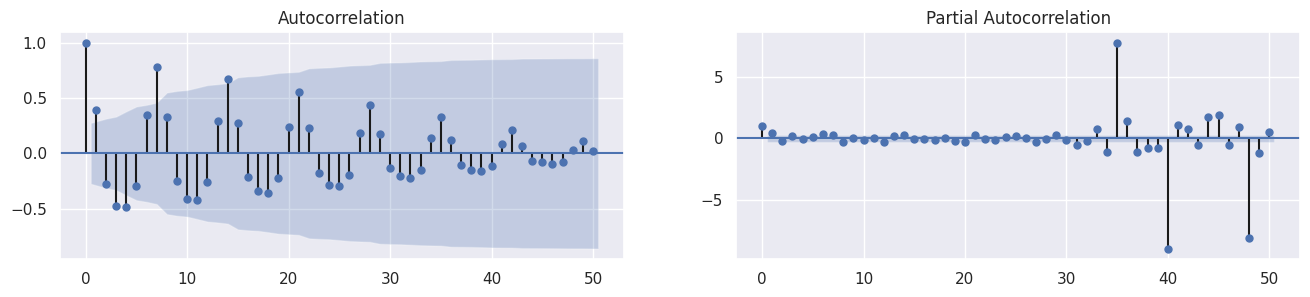

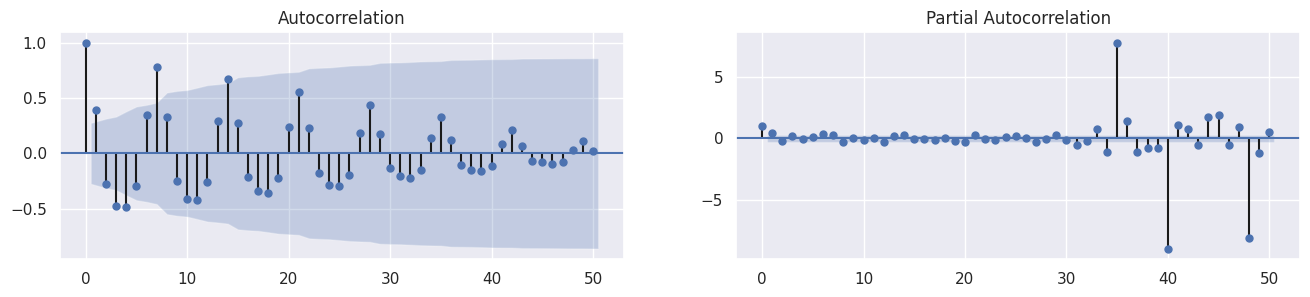

In [ ]:
# autocorrelacion
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt


# Calculate ACF and PACF upto 50 lags
acf_50 = acf(df_frau['num_del'], nlags=50)
pacf_50 = pacf(df_frau['num_del'], nlags=50)

# Draw Plot
fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(acf_50, lags=50, ax=axes[0])
plot_pacf(pacf_50, lags=50, ax=axes[1])

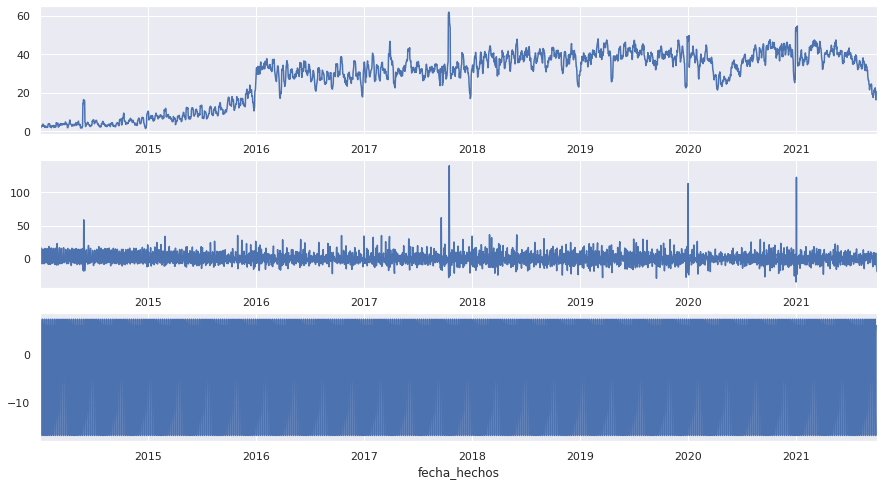

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
# Additive Decomposition
df_frau = df_frau.asfreq('d').fillna(0)
result_add = seasonal_decompose(df_frau['num_del'], model='additive', extrapolate_trend='freq')

# Plot

fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
result_add.trend.plot(ax=ax1)
result_add.resid.plot(ax=ax2)
result_add.seasonal.plot(ax=ax3)

In [ ]:
# Extract the Components ----
df_reconstructed = pd.concat([result_add.seasonal, result_add.trend, result_add.resid, result_add.observed], axis=1)
df_reconstructed.columns = ['Seasonality', 'Trend', 'Residual', 'Actual_values']
df_reconstructed.head()

,Seasonality,Trend,Residual,Actual_values
fecha_hechos,,,,
2014-01-02,5.514230,1.683673,-5.197904,2.0
2014-01-03,7.172826,1.821429,-6.994254,2.0
2014-01-04,-11.922282,1.959184,9.963098,0.0
2014-01-05,-16.992397,1.714286,16.278111,1.0
2014-01-06,4.761139,2.428571,-3.189710,4.0


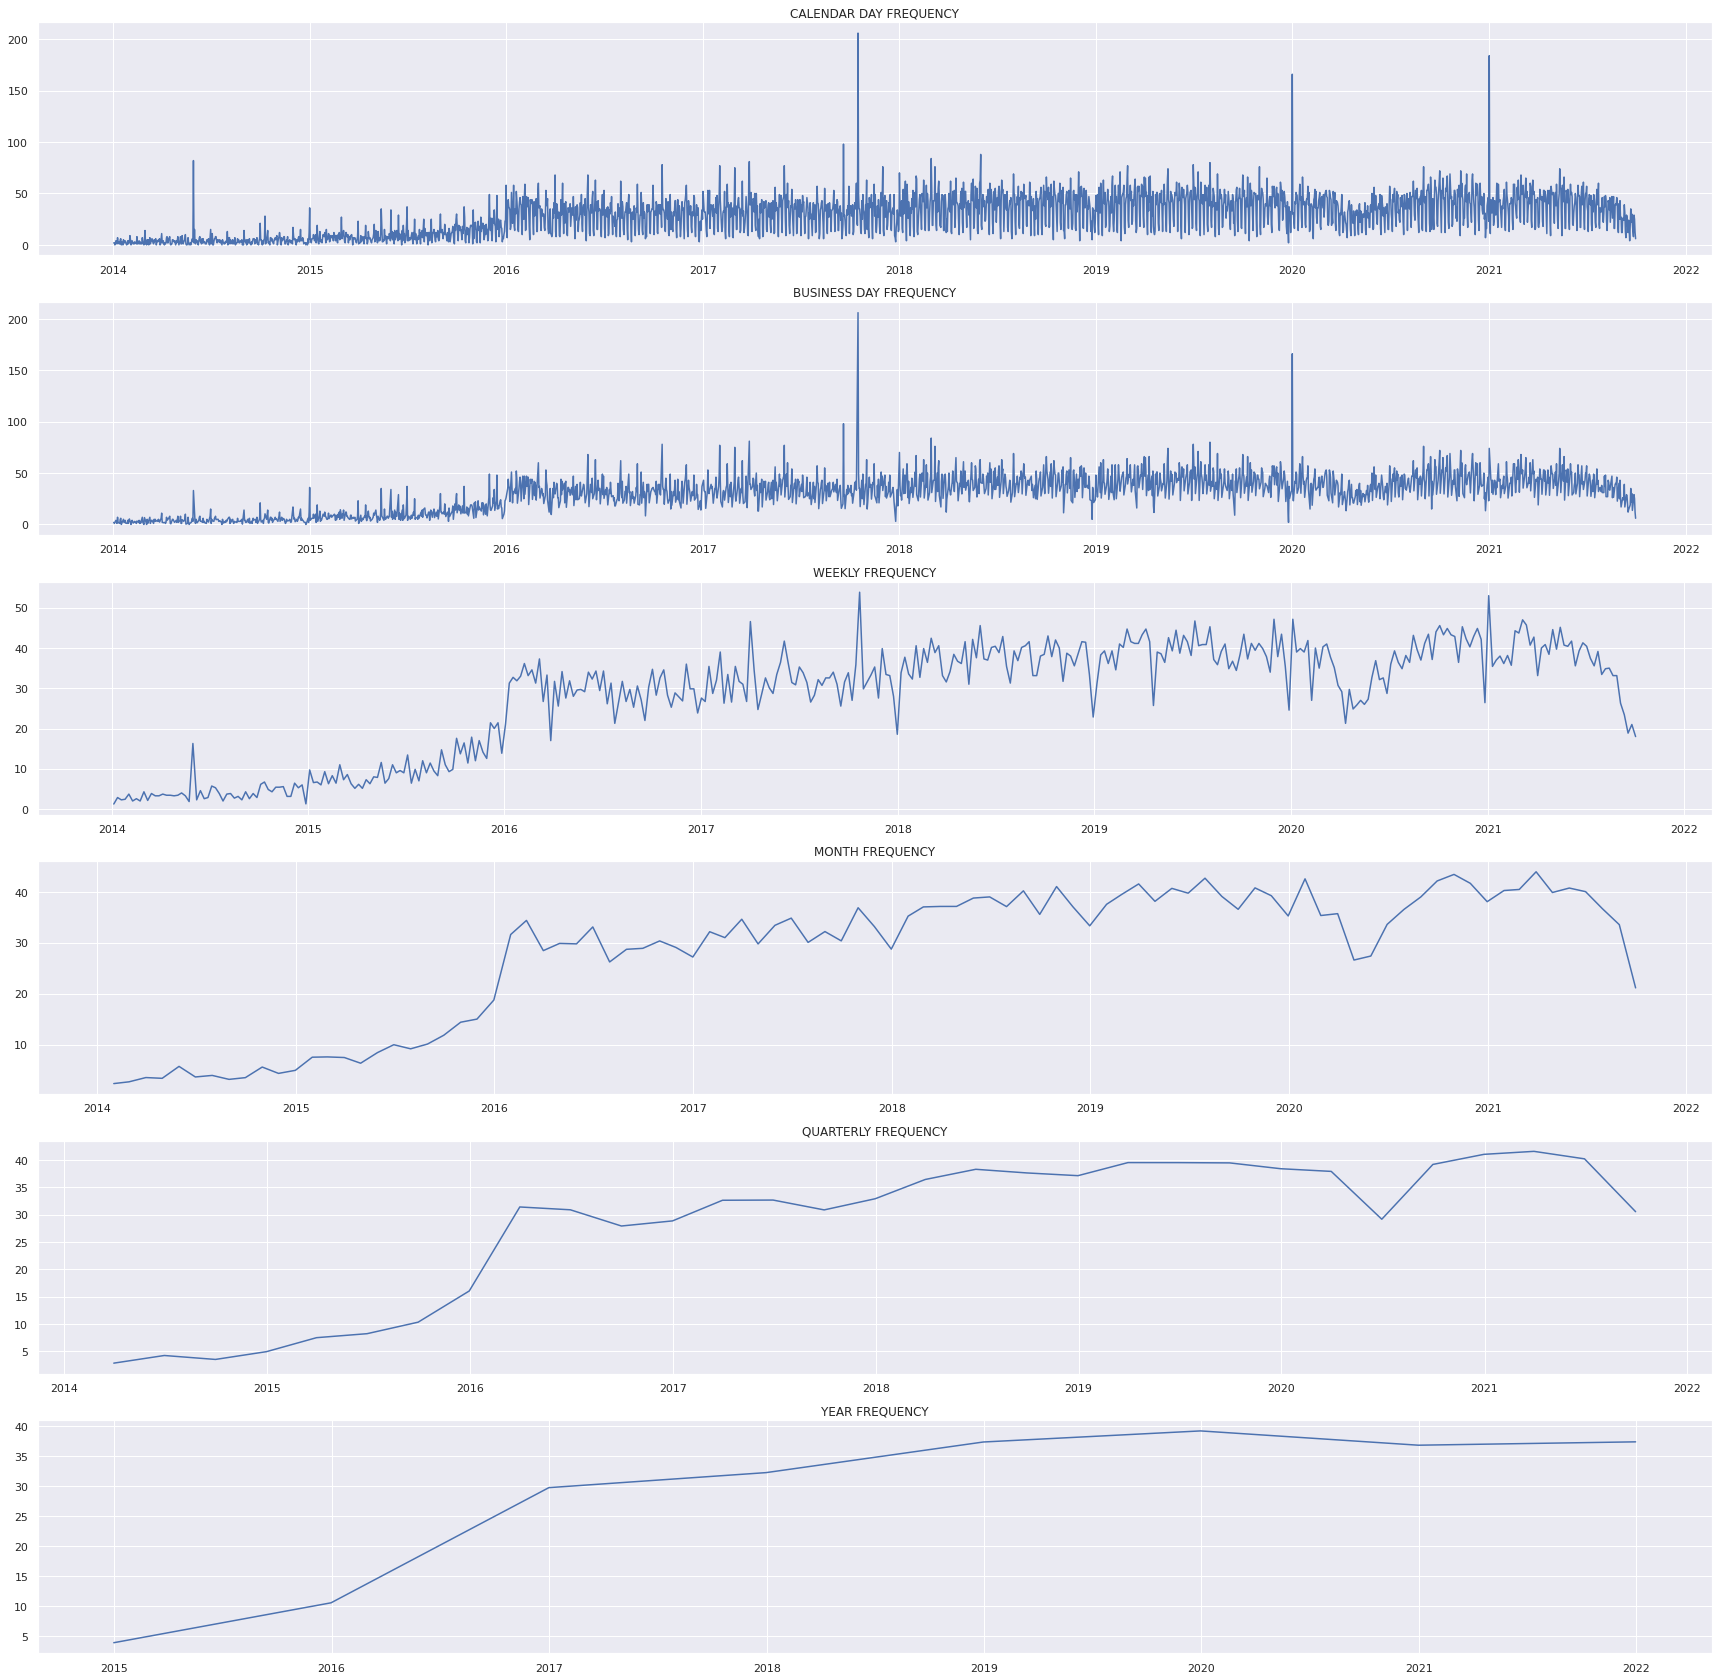

In [ ]:
fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,figsize=(30,30))

ax1.plot(df_frau.resample('D').mean())
ax1.set_title('CALENDAR DAY FREQUENCY');

ax2.plot(df_frau.resample('B').mean())
ax2.set_title('BUSINESS DAY FREQUENCY');

ax3.plot(df_frau.resample('W').mean())
ax3.set_title('WEEKLY FREQUENCY');

ax4.plot(df_frau.resample('M').mean())
ax4.set_title('MONTH FREQUENCY');

ax5.plot(df_frau.resample('Q').mean())
ax5.set_title('QUARTERLY FREQUENCY');

ax6.plot(df_frau.resample('A').mean())
ax6.set_title('YEAR FREQUENCY');

In [ ]:
week_mean_df=df.groupby(df.index.dayofweek).mean().reset_index().rename(columns={"date": "Day", "humidity": "humidity_mean"})
week_mean_df.set_index("Day", drop=True, inplace=True)

month_mean_df=df.groupby(df.index.month).mean().reset_index().rename(columns={"date": "Month", "humidity": "humidity_mean"})
month_mean_df.set_index("Month", drop=True, inplace=True)

year_mean_df=df.groupby(df.index.year).mean().reset_index().rename(columns={"date": "Year", "humidity": "humidity_mean"})
year_mean_df.set_index("Year", drop=True, inplace=True)

week_mean_df['Percentage_increase']=(week_mean_df.pct_change().fillna(0))*100
month_mean_df['Percentage_increase']=month_mean_df.pct_change().fillna(0)*100
year_mean_df['Percentage_increase']=year_mean_df.pct_change().fillna(0)*100

In [ ]:
# a partir de lo detectado podemos usar funcion sencilla para ver la tendencia 
def tendencia(tiempo, datos, order=1):
    result = np.polyfit(tiempo, datos, order)
    slope = result[-2]
    return float(slope)

In [ ]:
ten = tendencia(df_frau.index.map(dt.datetime.toordinal), df_frau, 1)
print("La pendiente ")

0.09369512836810229

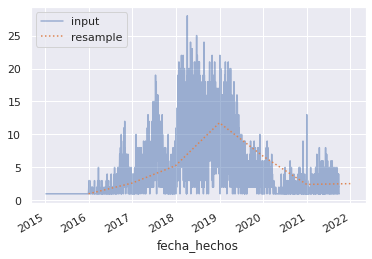

In [ ]:
ax = dataTsF[dataTsF['delito'] == 'ROBO A PASAJERO A BORDO DE METRO SIN VIOLENCIA'].drop(columns=['delito']).plot(alpha=0.5, style='-')
dataTsF[dataTsF['delito'] == 'ROBO A PASAJERO A BORDO DE METRO SIN VIOLENCIA'].drop(columns=['delito']).resample('BA').mean().plot(style=':', ax=ax)
# dataTsF[dataTsF['delito'] == 'VIOLENCIA FAMILIAR'].drop(columns=['delito']).asfreq('BA').plot(style='--', ax=ax)
plt.legend(['input', 'resample', 'asfreq'], loc='upper left')

UFuncTypeError: ignored

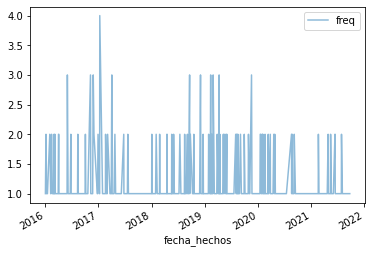

In [ ]:
dataTs[(dataTs['delito'] == 'ABORTO') & (dataTs.index > "2016")].plot(alpha=0.5, style='-')

In [ ]:
dataTs.groupby('delito').count().sort_values(by='freq')

,freq
delito,
ROBO DE VEHICULO Y NOMINA CON VIOLENCIA,1
CONTRA LA LEY GENERAL DE EXPLOSIVOS,1
DESACATO,1
EJERCICIO INDEBIDO DEL PROPIO DER.,1
ASOCIACION DELICTUOSA,1
...,...
DESPOJO,2599
DENUNCIA DE HECHOS,2671
VIOLENCIA FAMILIAR,2682


In [ ]:

data.head(2)

,ao_hechos,mes_hechos,fecha_hechos,ao_inicio,mes_inicio,fecha_inicio,delito,fiscalia,agencia,unidad_investigacion,categoria_delito,calle_hechos,calle_hechos2,colonia_hechos,alcaldia_hechos,competencia,longitud,latitud,tempo
0,2016.0,Enero,2016-01-31 22:16:00,2016,Febrero,2016-02-01 00:25:44,DAÑO EN PROPIEDAD AJENA INTENCIONAL,INVESTIGACIÓN EN BENITO JUÁREZ,BJ-2,UI-3CD,DELITO DE BAJO IMPACTO,CALZ. DE TLALPAN,LAGO PTE.,AMÉRICAS UNIDAS,BENITO JUAREZ,NaN,-99.140215,19.380315,NaN
1,2016.0,Enero,2016-01-31 20:50:00,2016,Febrero,2016-02-01 00:52:37,ROBO DE VEHICULO DE SERVICIO PARTICULAR CON VI...,INVESTIGACIÓN PARA LA ATENCIÓN DEL DELITO DE R...,ORIENTEII,UI-3CD,ROBO DE VEHÍCULO CON Y SIN VIOLENCIA,SUR 25 A,GRANJEROS,LOS CIPRESES,IZTAPALAPA,NaN,-99.108403,19.352859,NaN


In [ ]:
"delito"].value_counts(normalize=True)

VIOLENCIA FAMILIAR                         1.052485e-01
FRAUDE                                     6.275345e-02
ROBO DE OBJETOS                            5.811839e-02
AMENAZAS                                   5.476928e-02
ROBO A NEGOCIO SIN VIOLENCIA               5.167261e-02
                                               ...     
DESACATO                                   7.649874e-07
UTILIZACION INDEBIDA DE LA VIA PUBLICA     7.649874e-07
EJERCICIO INDEBIDO DEL PROPIO DER.         7.649874e-07
CONTRA LA LEY GENERAL DE EXPLOSIVOS        7.649874e-07
ROBO DE VEHICULO Y NOMINA CON VIOLENCIA    7.649874e-07
Name: delito, Length: 345, dtype: float64

In [ ]:
# vamos a clasificar los delitos por año, mes y tipo, de esta forma podremos tener una serie de tiempo y ver que delitos van a la alza o a la baja
data_cp = data.head(200)
data_gp = data.groupby(['ao_hechos', 'mes_hechos'])['delito'].value_counts()

In [ ]:
data_gp

NameError: ignored